### LASSO parameter range experiments

We want to see whether smaller models (i.e. models with fewer nonzero features) tend to generalize to new cancer types better than larger ones; this script compares/visualizes those results.

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
base_results_dir = os.path.join(
    cfg.repo_root, '10_msi_prediction', 'results', 'msi_lasso_range'
)

training_dataset = 'all_other_cancers'
results_dir = os.path.join(base_results_dir, training_dataset)

metric = 'aupr'
nz_cutoff = 5.0

output_plots = False
output_plots_dir = None

### Get coefficient information for each lasso penalty

In [3]:
nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range_msi(results_dir):
    (cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        nz_coefs_df.append(
            [cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
nz_coefs_df = pd.DataFrame(
    nz_coefs_df,
    columns=['cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
nz_coefs_df.lasso_param = nz_coefs_df.lasso_param.astype(float)
nz_coefs_df.head()

,cancer_type,lasso_param,seed,fold,nz_coefs
0,STAD,0.000001,1,0,16142
1,STAD,0.000001,1,1,16141
2,STAD,0.000001,1,2,16140
3,STAD,0.000001,1,3,16141
4,COAD,0.005000,1,0,6976


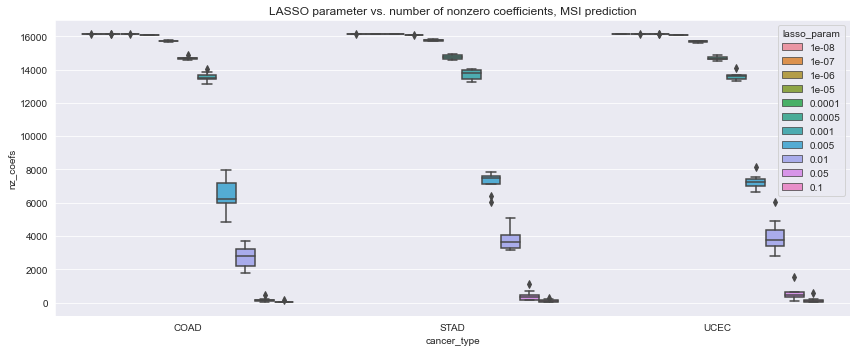

In [4]:
sns.set({'figure.figsize': (12, 5)})

sns.boxplot(
    data=nz_coefs_df.sort_values(by=['cancer_type', 'lasso_param']),
    x='cancer_type', y='nz_coefs', hue='lasso_param'
)
plt.title(f'LASSO parameter vs. number of nonzero coefficients, MSI prediction')
plt.tight_layout()

### Get performance information for each lasso penalty

In [5]:
perf_df = au.load_prediction_results_lasso_range_msi(results_dir, training_dataset)
perf_df.drop(columns=['gene'], inplace=True)
perf_df.lasso_param = perf_df.lasso_param.astype(float).apply(lambda x: f'{x:.8f}')

perf_df.head()

,auroc,aupr,holdout_cancer_type,signal,seed,data_type,fold,experiment,lasso_param
0,1.00000,1.00000,STAD,signal,1,train,0,all_other_cancers,0.00000010
1,0.99238,0.97616,STAD,signal,1,test,0,all_other_cancers,0.00000010
2,0.96792,0.93647,STAD,signal,1,cv,0,all_other_cancers,0.00000010
3,1.00000,1.00000,STAD,signal,1,train,1,all_other_cancers,0.00000010
4,0.96250,0.90091,STAD,signal,1,test,1,all_other_cancers,0.00000010


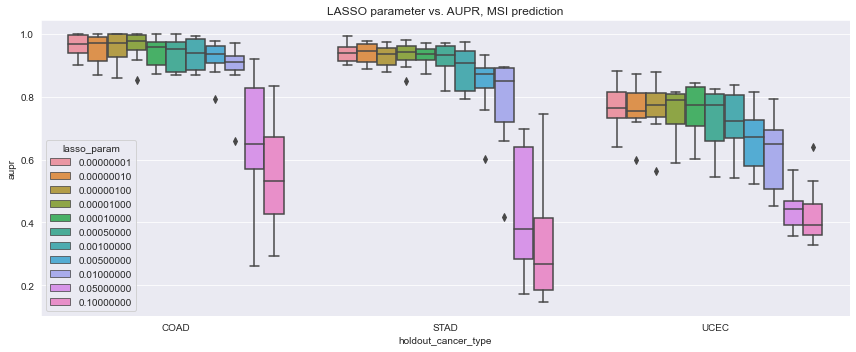

In [6]:
sns.set({'figure.figsize': (12, 5)})

sns.boxplot(
    data=(
        perf_df[(perf_df.signal == 'signal') &
                (perf_df.data_type == 'test')]
          .sort_values(by=['holdout_cancer_type', 'lasso_param'])
    ), x='holdout_cancer_type', y=metric, hue='lasso_param'
)
plt.title(f'LASSO parameter vs. {metric.upper()}, MSI prediction')
plt.tight_layout()

if output_plots:
    output_plots_dir.mkdir(exist_ok=True)
    plt.savefig(output_plots_dir / f'msi_lasso_boxes.png',
                dpi=200, bbox_inches='tight')

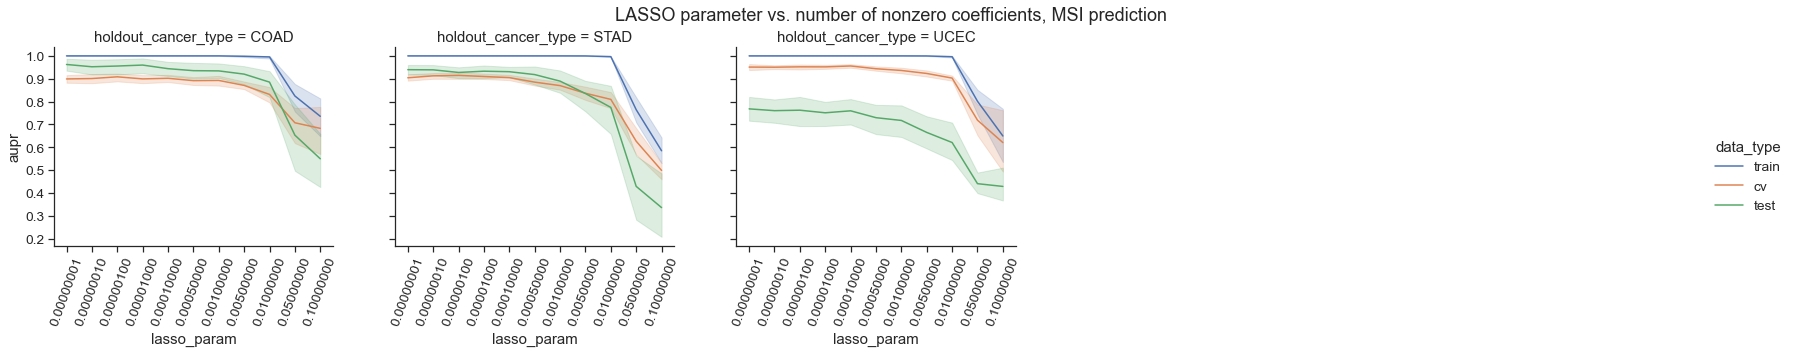

In [7]:
sns.set({'figure.figsize': (12, 5)})
sns.set_style('ticks')

plot_df = (
    perf_df[(perf_df.signal == 'signal')]
      .sort_values(by=['holdout_cancer_type', 'lasso_param'])
      .reset_index(drop=True)
)

with sns.plotting_context('notebook', font_scale=1.25):
    g = sns.relplot(
        data=plot_df,
        x='lasso_param', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        kind='line', col='holdout_cancer_type',
        col_wrap=5, height=4, aspect=1.2
    )
    g.set_xticklabels(rotation=70)
    plt.suptitle(f'LASSO parameter vs. number of nonzero coefficients, MSI prediction', y=1.025)

if output_plots:
    plt.savefig(output_plots_dir / f'msi_lasso_facets.png',
                dpi=200, bbox_inches='tight')

/home/jake/miniconda3/envs/pc-eval/lib/python3.8/site-packages/seaborn/axisgrid.py:38: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(**kwargs)


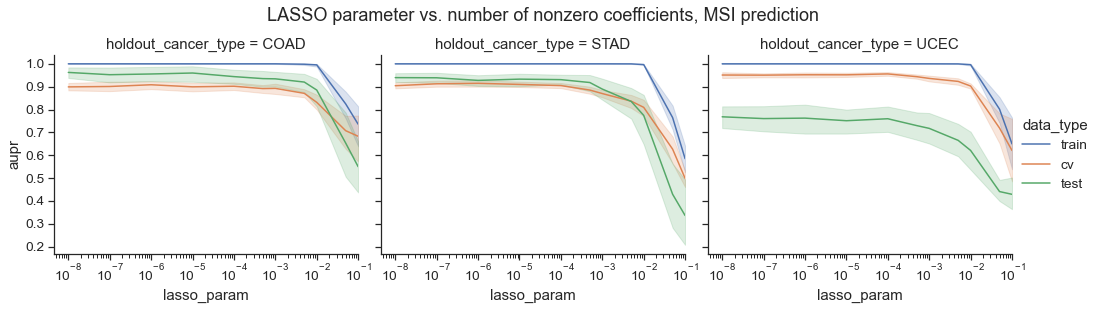

In [8]:
sns.set({'figure.figsize': (12, 5)})
sns.set_style('ticks')

plot_df = (
    perf_df[(perf_df.signal == 'signal')]
      .sort_values(by=['holdout_cancer_type', 'lasso_param'])
      .reset_index(drop=True)
)
plot_df.lasso_param = plot_df.lasso_param.astype(float)

with sns.plotting_context('notebook', font_scale=1.25):
    g = sns.relplot(
        data=plot_df,
        x='lasso_param', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        kind='line', col='holdout_cancer_type',
        col_wrap=3, height=4, aspect=1.2
    )
    g.set(xscale='log', xlim=(0, 0.1))
    # g.set_xticklabels(rotation=70)
    plt.suptitle(f'LASSO parameter vs. number of nonzero coefficients, MSI prediction', y=1.05)

if output_plots:
    plt.savefig(output_plots_dir / f'msi_lasso_facets.png',
                dpi=200, bbox_inches='tight')